# Breast Histopathology Classification 🥇

Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

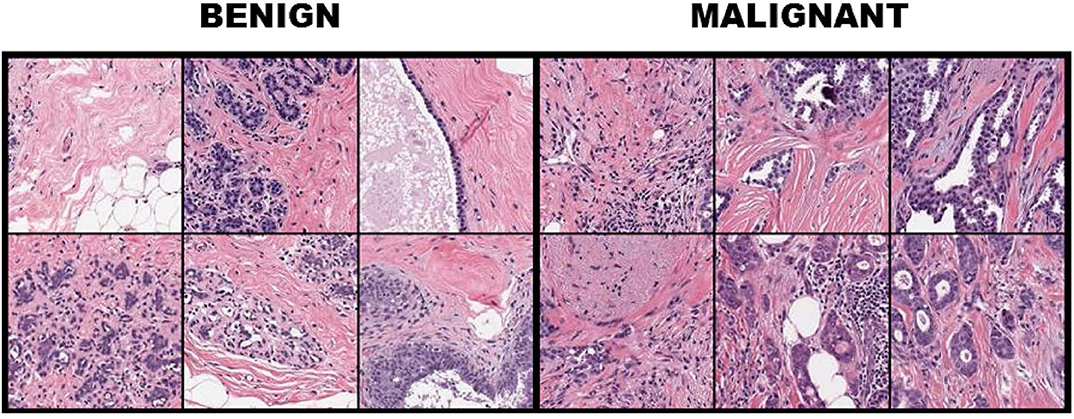

## Download Data from Kaggle

In [1]:
! pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:49<00:00, 29.8MB/s]
100% 3.10G/3.10G [00:49<00:00, 67.7MB/s]


In [5]:
! unzip breast-histopathology-images.zip -d breast_cancer_images

Streaming output truncated to the last 5000 lines.
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: breast_cancer_images/IDC_regular_ps50_idx5/9346/0/9346

## Packages

In [8]:
# Import neccessary packages
import pandas as pd
import numpy as np
import cv2
import os
from glob import glob
import random
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

In [ ]:
# Envirenement SetUp for TPU usage
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Exploratory Data Analysis

In [11]:
# Loading images paths
imagePatches = glob('breast_cancer_images/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)
print("Images paths loaded successfully!")

breast_cancer_images/13458/0/13458_idx5_x851_y1001_class0.png
breast_cancer_images/13458/0/13458_idx5_x801_y1001_class0.png
breast_cancer_images/13458/0/13458_idx5_x151_y1001_class0.png
breast_cancer_images/13458/0/13458_idx5_x1101_y1351_class0.png
breast_cancer_images/13458/0/13458_idx5_x1301_y1351_class0.png
breast_cancer_images/13458/0/13458_idx5_x501_y1051_class0.png
breast_cancer_images/13458/0/13458_idx5_x251_y851_class0.png
breast_cancer_images/13458/0/13458_idx5_x801_y901_class0.png
breast_cancer_images/13458/0/13458_idx5_x1101_y1201_class0.png
breast_cancer_images/13458/0/13458_idx5_x1301_y1401_class0.png
Images paths loaded successfully!


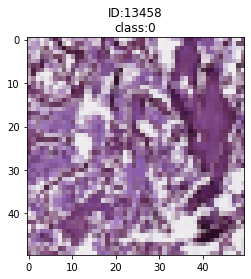

In [ ]:
# Show a sample image
img_sample = cv2.imread(imagePatches[0])
plt.title('ID:'
          +str(imagePatches[0].split('/')[3].split('_')[0])+'\n'
         'class:'+str(imagePatches[0].split('/')[2]))
plt.imshow(img_sample)

In [56]:
patients1 = ["_".join(x.split("/")[3].split("_")[:2]) for x in imagePatches 
             if len(x.split("/"))<=4]

patients2 = ["_".join(x.split("/")[4].split("_")[:2]) for x in imagePatches 
             if len(x.split("/"))>4]

classes = {"0":"Benign","1":"Malignant"}
diagnosis = [classes["0" if x.endswith("class0.png") else "1"] for x in imagePatches]
data = pd.DataFrame({"patients":patients1 + patients2, "diagnosis": diagnosis})
data.head()

,patients,diagnosis
0,13458_idx5,Benign
1,13458_idx5,Benign
2,13458_idx5,Benign
3,13458_idx5,Benign
4,13458_idx5,Benign


In [43]:
data["patients"].value_counts()

13693_idx5    4790
16550_idx5    4604
10308_idx5    4556
10288_idx5    4556
9323_idx5     4432
              ... 
16895_idx5     302
9175_idx5      236
8957_idx5      222
9262_idx5      188
16534_idx5     126
Name: patients, Length: 279, dtype: int64

Text(0.5, 1.0, 'Distribution of the classes in our Data')

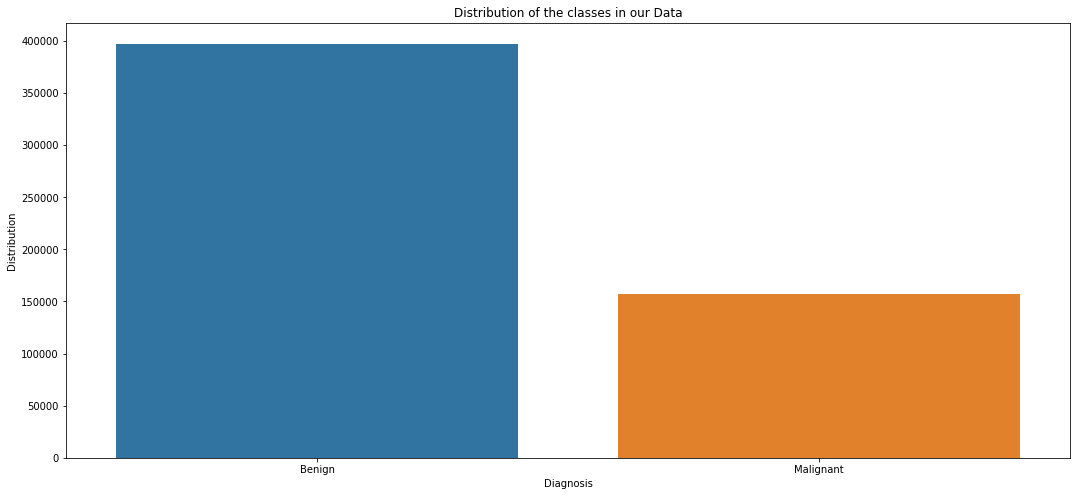

In [57]:
import seaborn as sns
data_diagnosis = data["diagnosis"].value_counts()
plt.figure(figsize=(18,8))
sns.barplot(x = data_diagnosis.keys().to_list(), y=data_diagnosis.values)
plt.xlabel("Diagnosis")
plt.ylabel("Distribution")
plt.title("Distribution of the classes in our Data")

In [58]:
data_diagnosis

Benign       397476
Malignant    157572
Name: diagnosis, dtype: int64

**We are going to train our model with equivalent classes 157572 each**

In [52]:
class0 = [] # 0 = Malignant
class1 = [] # 1 = Benign

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [55]:
print("imagePatches",len(imagePatches))
print("class0", len(class0))
print("class1", len(class1))

imagePatches 555048
class0 397476
class1 157572


In [59]:
sampled_class0 = random.sample(class0, 157572)
sampled_class1 = random.sample(class1, 157572)

In [60]:
# Read images with labels
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [61]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


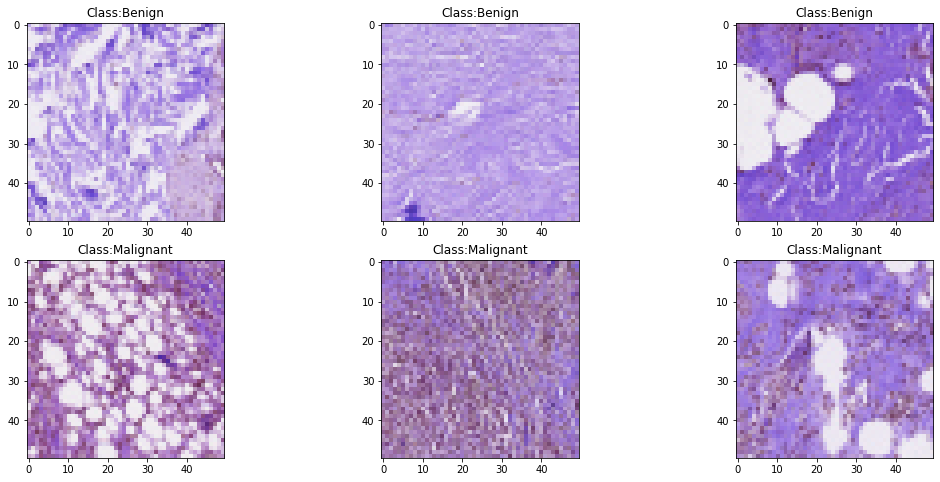

In [102]:
# Show Images from the two classes
images_arr = np.concatenate((class0_array[:3],class1_array[:3]))
fig = plt.figure(figsize=(18,8))
index = 1
rows = 2
columns = 3
for im, label in images_arr:
  fig.add_subplot(rows,columns,index)
  plt.imshow(im)
  plt.title("Class:" + classes[str(label)])
  index += 1

In [ ]:
# Combine data from two classes
import numpy as np
combined_data = np.concatenate((class0_array, class1_array))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
X = []
y = []
for features,label in combined_data:
    X.append(features)
    y.append(label)

In [ ]:
X = np.array(X).reshape(-1, 50, 50, 3)
y = np.array(y)

## Training set and test set

In [ ]:
# Data Spliting
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
X_test = X_valid
y_test = y_valid
# Delete unusable variable to reduce the Memory load
del X, combined_data, class0, class1, y, class0_array, class1_array, imagePatches


In [ ]:
# Transformer les labels
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(252115, 50, 50, 3) (63029, 50, 50, 3) (252115, 2) (63029, 2)


**Number of the training samples is 252115 and 63029 for the test**

## Création de modèle CNN

In [103]:
# Epochs and batch size
epochs = 25  
batch_size = 500

# Model's metrics
model_metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

# Checkpoints
model_cp = ModelCheckpoint('model.h5')

#Early Stoping
model_es = EarlyStopping(verbose=1, patience=5)

In [106]:
# Model Structure 
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(50,50,3),activation='relu', name="conv1"))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', name="conv2"))
model.add(MaxPool2D(pool_size=(3,3), name="maxp1"))
model.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu', name="conv3"))
model.add(MaxPool2D(pool_size=(5,5), name="maxp2"))
model.add(Dropout(0.3, name="dropout"))
model.add(Flatten(name="flatten"))
model.add(Dense(128,activation='relu',name="dense1"))
model.add(Dense(64,activation='relu', name="dense2"))
model.add(Dense(2,activation='sigmoid', name="dense3"))

model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= model_metrics)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 48, 48, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 46, 46, 32)        9248      
                                                                 
 maxp1 (MaxPooling2D)        (None, 15, 15, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 11, 11, 32)        25632     
                                                                 
 maxp2 (MaxPooling2D)        (None, 2, 2, 32)          0         
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 flatten (Flatten)           (None, 128)               0

## Training

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    verbose = 1,
    batch_size=batch_size,
    callbacks=[model_cp,model_es]
    )

Epoch 1/25
505/505 [==============================] - 82s 160ms/step - loss: 0.6028 - accuracy: 0.7717 - precision: 0.7721 - recall: 0.7709 - auc: 0.8322 - val_loss: 0.4496 - val_accuracy: 0.8015 - val_precision: 0.8052 - val_recall: 0.7953 - val_auc: 0.8780
Epoch 2/25
505/505 [==============================] - 75s 149ms/step - loss: 0.4440 - accuracy: 0.8017 - precision: 0.8018 - recall: 0.8015 - auc: 0.8751 - val_loss: 0.4300 - val_accuracy: 0.8086 - val_precision: 0.8109 - val_recall: 0.8049 - val_auc: 0.8845
Epoch 3/25
505/505 [==============================] - 76s 150ms/step - loss: 0.4272 - accuracy: 0.8113 - precision: 0.8111 - recall: 0.8115 - auc: 0.8851 - val_loss: 0.4179 - val_accuracy: 0.8222 - val_precision: 0.8226 - val_recall: 0.8215 - val_auc: 0.8955
Epoch 4/25
505/505 [==============================] - 76s 151ms/step - loss: 0.4108 - accuracy: 0.8211 - precision: 0.8214 - recall: 0.8206 - auc: 0.8944 - val_loss: 0.4124 - val_accuracy: 0.8228 - val_precision: 0.8217 - v

## Evaluation

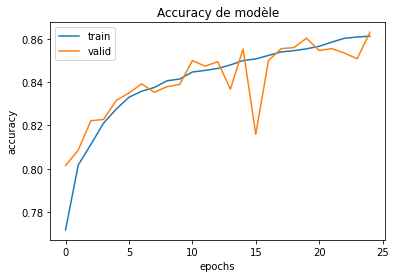

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy de modèle')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)

In [ ]:
Y_t = []
for y in Y_pred:
  Y_t.append(np.argmax(y, axis=0))
  
Y_true = np.array(Y_t)

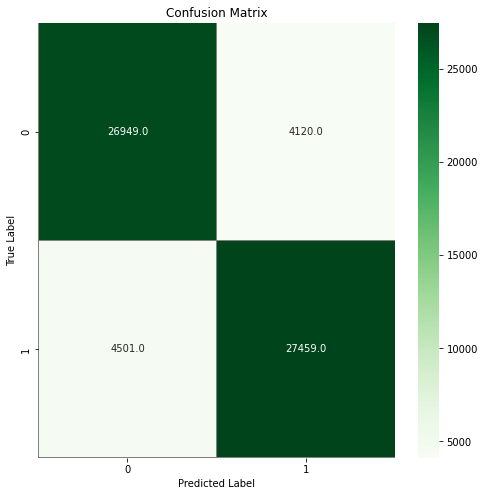

In [ ]:
confusion_mtx = confusion_matrix(Y_true, y_test) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Results Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, y_test))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     31069
           1       0.87      0.86      0.86     31960

    accuracy                           0.86     63029
   macro avg       0.86      0.86      0.86     63029
weighted avg       0.86      0.86      0.86     63029



Made With ♥ by Hassan Abida | Data Science Student @ FSTG Marrakesh [LinkedIn](https://www.linkedin.com/in/hassan-abida/)